In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sklearn.linear_model as linear
import sklearn.preprocessing as pre
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import time
import warnings
from typing import overload, Callable
from dataclasses import dataclass

from main import (
    Curve,
    get_curves,
    loss,
    max_profit,
    convexify,
    lookup_to_tp_fp,
    ternary_search,
    equal_demographic,
    equal_odds,
    equal_opportunity,
    preprocess,
    intersection_threshold
)

In [2]:
with open('adult.names') as file:
    rows = file.read().split('\n')[-15:]
    col_names = [row.split(':')[0] for row in rows][:-1] + ['label']

x, y, labels, label_map = preprocess(
    fname='adult.data',
    col_names=col_names,
    protected='sex'
)

In [3]:
model = linear.LogisticRegression(penalty='none', max_iter=2000, verbose=True)
with warnings.catch_warnings():
    warnings.filterwarnings('error')
    try:
        model.fit(x, y)
    except Warning as w:
        print(w)
        exit(1)
probs = model.predict_proba(x)[:, 1]  # probability of y = 1
print(f'base model score: {model.score(x, y)}')
curves = get_curves(probs, labels, label_map, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.25696D+04    |proj g|=  1.38675D+07

At iterate   50    f=  1.64789D+04    |proj g|=  3.29235D+04

At iterate  100    f=  1.22304D+04    |proj g|=  8.14002D+04

At iterate  150    f=  1.11946D+04    |proj g|=  4.94400D+03

At iterate  200    f=  1.07759D+04    |proj g|=  9.29299D+03

At iterate  250    f=  1.07487D+04    |proj g|=  5.94089D+03

At iterate  300    f=  1.06717D+04    |proj g|=  8.49872D+03

At iterate  350    f=  1.06242D+04    |proj g|=  1.74821D+04

At iterate  400    f=  1.06230D+04    |proj g|=  2.84975D+03

At iterate  450    f=  1.06204D+04    |proj g|=  1.68495D+03

At iterate  500    f=  1.06181D+04    |proj g|=  4.52057D+03

At iterate  550    f=  1.06085D+04    |proj g|=  8.27134D+03

At iterate  600    f=  1.06022D+04    |proj g|=  2.28090D+04

At iterate  650    f=  1.0

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s finished
/Users/leevi/repos/stat-ml-project/main.py:119: RuntimeWarning: divide by zero encountered in divide
  slopes = np.diff(tp) / np.diff(fp)
/Users/leevi/repos/stat-ml-project/main.py:119: RuntimeWarning: divide by zero encountered in divide
  slopes = np.diff(tp) / np.diff(fp)


In [4]:
# check blind model max
fpr, tpr, th = metrics.roc_curve(y, probs)
i = loss(tpr, fpr, y.mean()).argmin()
bm = tpr[i], fpr[i], th[i]
th[i]

0.5029358337814798

In [20]:
mp = max_profit(curves)
print(f'max profit: {mp}')

ed = equal_demographic(curves)
print(f'equal demographic: {ed}')

eopp = equal_opportunity(curves)
print(f'equal opportunity: {eopp}')

eodd = equal_odds(curves)
print(f'equal odds: {eodd}')

max profit: (array([0.50299862, 0.51757613]), array([0.60927649, 0.50890585]), array([0.09485722, 0.02126772]))
0.15968794499663552
equal demographic: (array([[0.67475601, 0.63130422],
       [0.2287213 , 0.22034834]]), array([0.43493739, 0.77523303]), array([0.03847484, 0.08402826]), 0.15968794499663552, array([0.66873575, 0.22034861]))
0.5633445124641188
equal opportunity: (array([[0.54797703, 0.50299862],
       [0.45219853, 0.4199356 ]]), array([0.56334451, 0.56334451]), array([0.07608415, 0.02901264]), 0.5633445124641188, array([0.54797687, 0.45188748]))
equal odds: (0.5250673141627535, 0.06326010647013411)


In [6]:
pis = np.array([curve.pi for curve in curves])
shares = np.array([curve.share for curve in curves])
print(pis)
print(shares)

[0.30573658 0.10946059]
[0.66920549 0.33079451]


In [7]:
bm[2]

0.5029358337814798

In [8]:
# tabulate losses
loss_table = pd.Series(
    data={
        'blind': 1 - ((probs >= bm[2]) * 1 == y).mean(),
        'max profit': loss(mp[1], mp[2], pis).dot(shares),
        'demographic parity': loss(ed[1], ed[2], pis).dot(shares),
        'equal opportunity': loss(eopp[1], eopp[2], pis).dot(shares),
        'equal odds': loss(eodd[0], eodd[1], pis).dot(shares),
    }
)
loss_table.index.name = 'predictor'
loss_table.name = 'loss'
loss_table

predictor
blind                 0.148245
max profit            0.148061
demographic parity    0.166380
equal opportunity     0.149047
equal odds            0.162395
Name: loss, dtype: float64

In [9]:
loss_table.to_latex('loss.tex', float_format='%.4f')

/var/folders/nc/dhtws2m1317bwzbsxq9n3_gc0000gn/T/ipykernel_1900/494938161.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  loss_table.to_latex('loss.tex', float_format='%.4f')


In [72]:
!cat loss.tex

\begin{tabular}{lr}
\toprule
{} &   loss \\
predictor          &        \\
\midrule
blind              & 0.1482 \\
max profit         & 0.1481 \\
demographic parity & 0.1664 \\
equal opportunity  & 0.1490 \\
equal odds         & 0.1624 \\
\bottomrule
\end{tabular}


In [10]:
# max profit thresholds
mp[0]

array([0.50299862, 0.51757613])

In [11]:
# equal demographic thresholds
ed[0]

array([[0.67475601, 0.63130422],
       [0.2287213 , 0.22034834]])

In [12]:
# equal opportunity thresholds
eopp[0]

array([[0.54797703, 0.50299862],
       [0.45219853, 0.4199356 ]])

In [19]:
ed

(array([[0.67475601, 0.63130422],
        [0.2287213 , 0.22034834]]),
 array([0.43493739, 0.77523303]),
 array([0.03847484, 0.08402826]),
 0.15968794499663552,
 0.22034861065134437)

In [52]:
thresholds = pd.DataFrame(data={
    'max profit': mp[0],
    'blind': bm[2],
    'equal opportunity': eopp[4],
    'demographic parity': ed[-1],
}, index=label_map)
thresholds = thresholds.transpose()
thresholds.index.name = 'predictor'
thresholds.name = 'thresholds'
thresholds


,Male,Female
predictor,,
max profit,0.502999,0.517576
blind,0.502936,0.502936
equal opportunity,0.547977,0.451887
demographic parity,0.668736,0.220349


In [27]:
print(thresholds.to_latex(float_format='%.4f'))

\begin{tabular}{lrr}
\toprule
{} &   Male &  Female \\
predictor          &        &         \\
\midrule
blind              & 0.5029 &  0.5029 \\
max profit         & 0.5030 &  0.5176 \\
demographic parity & 0.6687 &  0.2203 \\
equal opportunity  & 0.5480 &  0.4519 \\
\bottomrule
\end{tabular}



/var/folders/nc/dhtws2m1317bwzbsxq9n3_gc0000gn/T/ipykernel_1900/856907552.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(thresholds.to_latex(float_format='%.4f'))


In [100]:
t.reindex(['blind', 'max profit', 'demographic parity', 'equal odds', 'equal opportunity'])

,Male,Female
predictor,,
blind,0.502936,0.502936
max profit,0.502999,0.517576
demographic parity,0.668736,0.220349
equal odds,NaN,NaN
equal opportunity,0.547977,0.451887


In [109]:
male_eodd_th = intersection_threshold(curves[0], *eodd)
female_eodd_th = intersection_threshold(curves[1], *eodd)

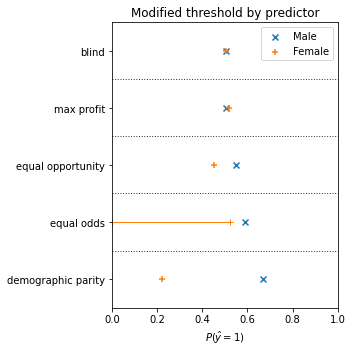

In [127]:
t = thresholds.copy()
# t.loc['equal odds'] = None
t = t.reindex(['blind', 'max profit', 'equal opportunity', 'equal odds', 'demographic parity']).iloc[::-1, :]
t.loc['equal odds', 'Male'] = male_eodd_th
n_rows = t.shape[0]
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(x=t['Male'], y=t.index, label='Male', marker='x')
f = ax.scatter(x=t['Female'], y=t.index, label='Female', marker='+')
ax.plot([0, female_eodd_th], [t.index.get_loc('equal odds'), t.index.get_loc('equal odds')], color='tab:orange', marker='+', linewidth=1)
# f.set_offsets((10, 10))
ax.legend()
ax.set_xlim(0, 1)
for i in range(n_rows - 1):
    ax.axhline(y=0.5 + i, linestyle=':', c='#333', linewidth=1)
ax.set_ylim(-0.5, 0.5 + n_rows - 1)
ax.set_xlabel('$P(\hat{y}=1)$')
ax.set_title('Modified threshold by predictor')
fig.tight_layout()
fig.savefig('thresholds.png', dpi=300)

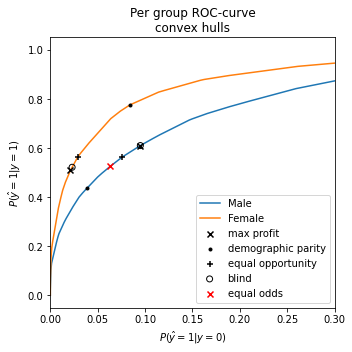

In [134]:
fig, ax = plt.subplots(figsize=(5, 5))
for curve in curves:
    ax.plot(curve.fps, curve.tps, label=curve.label, zorder=1)
for c, curve in enumerate(curves):
    ax.scatter(mp[2][c], mp[1][c], color='k', marker='x', label='max profit' if c == 0 else None)
    ax.scatter(ed[2][c], ed[1][c], color='k', marker='.', label='demographic parity' if c == 0 else None)
    ax.scatter(eopp[2][c], eopp[1][c], color='k', marker='+', label='equal opportunity' if c == 0 else None)
    _tp, _fp = lookup_to_tp_fp(bm[2], curve.ths[::-1], curve.tps[::-1], curve.fps[::-1])
    m = ax.scatter(_fp, _tp, color='k', marker='o', label='blind' if c == 0 else None)
    m.set_facecolor('none')
ax.scatter(eodd[1], eodd[0], color='red', marker='x', label='equal odds')
ax.legend(loc='lower right')
ax.set_ylabel('$P(\hat{y}=1|y=1)$')
ax.set_xlabel('$P(\hat{y}=1|y=0)$')
ax.set_title('Per group ROC-curve\nconvex hulls')
ax.set_xlim(0, 0.3)
fig.tight_layout()

fig.savefig('curves-zoomed.png', dpi=300)

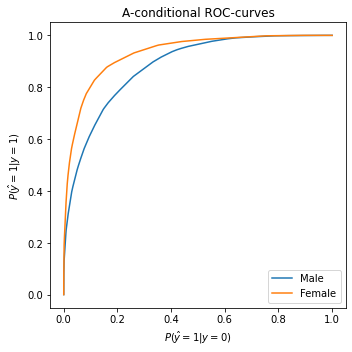

In [138]:
fig, ax = plt.subplots(figsize=(5, 5))
for curve in curves:
    ax.plot(curve.fps, curve.tps, label=curve.label, zorder=1)
# for c, curve in enumerate(curves):
#     ax.scatter(mp[2][c], mp[1][c], color='k', marker='x', label='max profit' if c == 0 else None)
#     ax.scatter(ed[2][c], ed[1][c], color='k', marker='.', label='demographic parity' if c == 0 else None)
#     ax.scatter(eopp[2][c], eopp[1][c], color='k', marker='+', label='equal opportunity' if c == 0 else None)
#     _tp, _fp = lookup_to_tp_fp(bm[2], curve.ths[::-1], curve.tps[::-1], curve.fps[::-1])
#     m = ax.scatter(_fp, _tp, color='k', marker='o', label='blind' if c == 0 else None)
#     m.set_facecolor('none')
# ax.scatter(eodd[1], eodd[0], color='red', marker='x', label='equal odds')
ax.legend(loc='lower right')
ax.set_ylabel('$P(\hat{y}=1|y=1)$')
ax.set_xlabel('$P(\hat{y}=1|y=0)$')
ax.set_title('A-conditional ROC-curves')
# ax.set_xlim(0, 0.3)
fig.tight_layout()

fig.savefig('rocs.png', dpi=300)

In [74]:
eodd

(0.5250673141627535, 0.06326010647013411)

0.5236138096134295

In [94]:
intersection_threshold(curves[0], *eodd)

0.5872496052093773

In [86]:
curve = curves[0]

tp, fp = eodd
def line(x: float) -> float:
    return (1 - tp) / (1 - fp) * (x - 1) + 1

ys = np.array([line(p) for p in curve.fps])
i = np.argmax(ys - curve.tps < 0)
phi = (1 - tp) / (1 - fp)
x1 = curve.fps[i-1]
x2 = curve.fps[i]
y1 = curve.tps[i-1]
y2 = curve.tps[i]



In [87]:
x1, y1

(0.06259915388683236, 0.5229660762533773)

In [88]:
x2, y2

(0.06326017979904812, 0.5250675472830981)

In [95]:
intersection_threshold(curves[1], *eodd)

0.5236138096134295